In [ ]:
# Import der Bibliotheken

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime
import plotly

In [ ]:
# Konfiguration der Grafiken

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.autolayout'] = False

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Definition von Funktionen

In [ ]:
# Funktion für die Abbildungen

def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(19,8))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

# Einlesen der Datenreihen

In [ ]:
# Einlesen externen Daten
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
#data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')
data_shipping_1 = pd.read_excel('data/Ferntransport_12.xlsx')

In [ ]:
# Erstellung eines Dataframes aus externen Daten

dataset_df=pd.DataFrame()
dataset_df['Zeitstempel']=data_pv['time']
dataset_df['PV_Erzeugung']=data_pv['electricity']
dataset_df['Wind_Erzeugung']=data_wind['electricity']
#dataset_df['Elektrolyse']=data_electrolysis['hydrogen']
dataset_df['Kapazität_Schiff']=data_shipping_1['10 Fahrten pro Jahr mit Betankung']
dataset_df.Kapazität_Schiff=dataset_df.Kapazität_Schiff.fillna(method='ffill')

In [ ]:
# Einlesen und Ausgabe der Inputs für die Variablen

data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0, nrows = 16)

data_inputs=pd.DataFrame(data_inputs.fillna(0)).drop(columns = ['Unnamed: 1','name','bus','p_nom','Unnamed: 10']).round(2)
data_inputs

# Definition der Variablen

In [ ]:
# Erstellung der Last durch den Wasserstoffbedarf

hydrogen_energy_content = 33 #kWh/kg oder MWh/t
hydrogen_demand_t = 35 * 1000
hydrogen_demand_kg = hydrogen_demand_t * 1000
hydrogen_demand_MWh = hydrogen_demand_t * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand_MWh/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

In [ ]:
# Erstellung der Last durch die Entsalzungsanlage

p_desalination = 0 #MWh/a)
print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs für die Entsalzungsanlage beträgt ungefähr ' + str(round(p_desalination,0)) + ' MWh')

## Investitionskosten

In [ ]:
# capital_cost

# Erzeugung
capital_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['capital_cost'] # €/MW
capital_cost_wind = data_inputs.loc['Windkraft (Chile)']['capital_cost'] # €/MW


# Elektrolyse
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW
#capital_cost_HTEL = 1300 # €/MW


# Umwandlung
capital_cost_LH2 = data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_NH3 = data_inputs.loc['Haber-Bosch']['capital_cost'] # €/MW
capital_cost_LOHC = data_inputs.loc['Hydrierung']['capital_cost'] # €/MW


#Transport
capital_cost_pipeline = data_inputs.loc['Pipeline']['capital_cost'] # €/MW
capital_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['capital_cost'] # €/MW
capital_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['capital_cost'] # €/MW


# Speicherung
capital_cost_storage_el = 1000000
capital_cost_storage_NH3 = data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LH2 = data_inputs.loc['NH3 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['capital_cost'] # €/MW
capital_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['capital_cost'] # €/MW

## Gestehungskosten

In [ ]:
# marginal_cost

# Erzeugung
marginal_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['marginal_cost'] # €/MWh
marginal_cost_wind = data_inputs.loc['Windkraft (Chile)']['marginal_cost'] # €/MWh

# Elektrolyse
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh
#marginal_cost_HTEL = 100 # €/MWh

# Umwandlung
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_NH3 = data_inputs.loc['Haber-Bosch']['marginal_cost'] # €/MWh
marginal_cost_LOHC = data_inputs.loc['Hydrierung']['marginal_cost'] # €/MWh

# Transport
marginal_cost_pipeline = data_inputs.loc['Pipeline']['marginal_cost'] # €/MWh
marginal_cost_shipping_LH2 = data_inputs.loc['LH2 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_NH3 = data_inputs.loc['NH3 Schiff']['marginal_cost'] # €/MWh
marginal_cost_shipping_LOHC = data_inputs.loc['LOHC Schiff']['marginal_cost'] # €/MWh

# Speicherung
marginal_cost_storage_el = 8000
marginal_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_NH3 = data_inputs.loc['NH3 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LOHC = data_inputs.loc['LOHC Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_GH2 = data_inputs.loc['GH2 Speicher']['marginal_cost'] # €/MWh

## Sonstiges

In [ ]:
# Wirkungsgrad Erzeugung
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency']
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency']
#efficiency_HTEL = 1

# Wirkungsgrad Umwandlung
efficiency_NH3 = data_inputs.loc['Haber-Bosch']['efficiency']
efficiency_LH2 = data_inputs.loc['Verflüssigung']['efficiency']
efficiency_LOHC = data_inputs.loc['Hydrierung']['efficiency']

# Lebenszeit
lifetime_PEMEL = data_inputs.loc['PEM Elektrolyse']['lifetime']
lifetime_AEL = data_inputs.loc['AEL Elektrolyse']['lifetime']
#lifetime_HTEL = 20

# Speicherverluste
standing_loss_el = 0.1
standing_loss_NH3 = data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_LH2 = data_inputs.loc['NH3 Speicher']['standing_loss']
standing_loss_LOHC = data_inputs.loc['LOHC Speicher']['standing_loss']
standing_loss_GH2 = data_inputs.loc['GH2 Speicher']['standing_loss']

# Netzwerk aufbauen

In [ ]:
network = pypsa.Network()
network.set_snapshots(range(8760))

## Buses

In [ ]:
# buses

network.add('Bus', name = 'electricity')
network.add('Bus', name = 'GH2')
network.add('Bus', name = 'LH2')
network.add('Bus', name = 'NH3')
network.add('Bus', name = 'LOHC')
network.add('Bus', name = 'bremerhaven')
network.add('Bus', name = 'cologne')

## Loads

In [ ]:
network.add('Load', name = 'hydrogen_demand', bus = 'cologne', 
            p_set = hydrogen_demand_hourly)

network.add('Load', name = 'desalination', bus = 'electricity', 
            p_set = p_desalination)

In [ ]:
dataset_df['PV_Erzeugung']

## Generators

In [ ]:
network.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
            p_max_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_min_pu = dataset_df['PV_Erzeugung']/dataset_df['PV_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'Windkraft', bus = 'electricity',
            p_max_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_min_pu = dataset_df['Wind_Erzeugung']/dataset_df['Wind_Erzeugung'].max(), 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

## Links - Electrolysis

In [ ]:
network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
            p_nom_extendable = True,
            lifetime = lifetime_PEMEL,
            marginal_cost = marginal_cost_PEMEL, 
            capital_cost = capital_cost_PEMEL,
            efficiency = efficiency_PEMEL)

network.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2',
            p_nom_extendable = True,
            lifetime = lifetime_AEL,
            marginal_cost = marginal_cost_AEL, 
            capital_cost = capital_cost_AEL,
            efficiency = efficiency_AEL)

#network.add('Link', name = 'HTEL', bus0 = 'electricity', bus1 = 'GH2',
#            p_nom_extendable = True,
#            lifetime = lifetime_HTEL,
#            marginal_cost = marginal_cost_HTEL, 
#            capital_cost = capital_cost_HTEL,
#            efficiency = efficiency_HTEL)

In [ ]:
# Veraltete Abbildung der Elektrolyse mit dem hinterlegten Volllastprofil von 8000 h/a

#network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
#            p_nom = dataset_df['Elektrolyse'].max(),
#            p_max_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_min_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_nom_extendable = True,
#            lifetime = lifetime_PEMEL,
#            marginal_cost = marginal_cost_PEMEL, 
#            capital_cost = capital_cost_PEMEL,
#            efficiency = efficiency_PEMEL)

## Links - Conversion

In [ ]:
network.add('Link', name = 'Verflüssigung', bus0 = 'GH2', bus1 = 'LH2',
            p_nom_extendable = True,
            marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
            efficiency = efficiency_LH2)

#network.add('Link', name = 'Haber-Bosch', bus0 = 'GH2', bus1 = 'NH3',
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_NH3, capital_cost = capital_cost_NH3,
#            efficiency = efficiency_NH3)

#network.add('Link', name = 'Hydrierung', bus0 = 'GH2', bus1 = 'LOHC',
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_LOHC, capital_cost = capital_cost_LOHC,
#            efficiency = efficiency_LOHC)

In [ ]:
# Veraltete Abbildung der Verflüssigung mit dem hinterlegten Volllastprofil von 8000 h/a

#network.add('Link', name = 'Verflüssigung', bus0 = 'GH2', bus1 = 'LH2',
#            p_nom = dataset_df['Elektrolyse'].max(),
#            p_max_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_min_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), 
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
#            efficiency = efficiency_LH2)

## Links - Cargoship

In [ ]:
network.add('Link', name = 'Verschiffung LH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = dataset_df['Kapazität_Schiff'].max(),
            p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
            p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_LH2, 
            capital_cost = capital_cost_shipping_LH2)

network.add('Link', name = 'Verschiffung NH3', bus0 = 'NH3', bus1 = 'bremerhaven',
            p_nom = dataset_df['Kapazität_Schiff'].max(),
            p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
            p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_NH3, 
            capital_cost = capital_cost_shipping_NH3)

network.add('Link', name = 'Verschiffung LOHC', bus0 = 'LOHC', bus1 = 'bremerhaven',
            p_nom = dataset_df['Kapazität_Schiff'].max(),
            p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), 
            p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_LOHC, 
            capital_cost = capital_cost_shipping_LOHC)

## Links - Pipeline

In [ ]:
network.add('Link', name = 'Pipeline', bus0 = 'bremerhaven', bus1 = 'cologne', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pipeline, 
            capital_cost = capital_cost_pipeline)

## Storages

In [ ]:
network.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_el,
            marginal_cost = marginal_cost_storage_el)

network.add('Store', name = 'Flüssigspeicher', bus = 'LH2', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LH2, 
            marginal_cost = marginal_cost_storage_LH2)

network.add('Store', name = 'Ammoniakspeicher', bus = 'NH3', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_NH3, 
            marginal_cost = marginal_cost_storage_NH3)

network.add('Store', name = 'LOHC-Speicher', bus = 'LOHC', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LOHC, 
            marginal_cost = marginal_cost_storage_LOHC)

network.add('Store', name = 'Gasspeicher', bus = 'bremerhaven', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2, 
            marginal_cost = marginal_cost_storage_GH2)

# Graphische Darstelung 

In [ ]:
Jahresverlauf('Stromerzeugung aus Windkraft',dataset_df.Zeitstempel.loc[2000:2055], dataset_df['Wind_Erzeugung'].loc[2000:2055],'Zeit','Leistung')

In [ ]:
Jahresverlauf('Stromerzeugung aus Photovoltaik',dataset_df.index, dataset_df['PV_Erzeugung'],'Zeit','Leistung')

In [ ]:
#Jahresverlauf('Elektrolyse',dataset_df.index, dataset_df['Elektrolyse'],'Zeit','Leistung')

In [ ]:
Jahresverlauf('Ferntransport',dataset_df.index, dataset_df['Kapazität_Schiff'],'Zeit','Leistung')

# Optimierung des Systems

In [ ]:
network.lopf(pyomo = False, solver_name = 'gurobi')

In [ ]:
network.graph()
network.iplot()

# Auswertung der Ergebnisse

In [ ]:
# Ausgabe einer Ergebnistabelle der Leistungen in MW und Kapazitäten in MWh

df_results_1 = pd.DataFrame(network.generators['p_nom_opt'])
df_results_2 = pd.DataFrame(network.links['p_nom_opt'])
df_results_3 = pd.DataFrame(network.stores['e_nom_opt'])

frames = [df_results_1, df_results_2, df_results_3]

results_x = (pd.concat(frames).round(2).fillna(0).rename(columns = {'p_nom_opt':'Leistung [MW]','e_nom_opt':'Kapazität [MWh]'}))
results = results_x.loc[(results_x.sum(axis=1) != 0), (results_x.sum(axis=0) != 0)]


results

In [ ]:
# Berechnung der jährlichen Volllaststunden

df_flh_1 = pd.DataFrame((network.generators_t.p.sum())/network.generators.p_nom_opt)
df_flh_2 = pd.DataFrame((network.links_t.p0.sum())/network.links.p_nom_opt)

df_flh_x = df_flh_1.append(df_flh_2).round(0).fillna(0)
df_flh = df_flh_x.loc[(df_flh_x.sum(axis=1) != 0), (df_flh_x.sum(axis=0) != 0)]
df_flh = df_flh.rename(columns = {0:'Volllast [h]'})
df_flh

In [ ]:
#TODO: Hier alle Ergebnisse (Leistung/Kapazität/Volllaststunden) in einen DF zu packen

results_sum = pd.concat([results,df_flh],axis=1)
results_sum

## Grafische Darstellungen

In [ ]:
# Darstellung der optimierten Erzeugungsleistung

ax = network.generators_t.p.plot()

plt.axhline(y=network.generators_t.p['Photovoltaik'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network.generators_t.p['Windkraft'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Nennleistung: '+str(network.generators.p_nom_opt.round(0)['Photovoltaik'])+' MW' , y = network.generators_t.p['Photovoltaik'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Nennleistung: '+str(network.generators.p_nom_opt.round(0)['Windkraft'])+' MW', y = network.generators_t.p['Windkraft'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.set_title('Erzeugungsleistung')
ax.set_ylabel("Leistung [MW]")
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()                  

In [ ]:
network.generators_t.p.info()

In [ ]:
# Darstellung der optimierten Elektrolyseleistung

fig, ax = plt.subplots()

ax.plot(network.links_t.p0['PEMEL'])
ax.plot(network.links_t.p0['AEL'])
#ax.plot(network.links_t.p0['HTEL'])

plt.axhline(y=network.links_t.p0['PEMEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")
plt.axhline(y=network.links_t.p0['AEL'].max(), xmin=0.01, xmax=0.99, color = 'black', linestyle = "--")

plt.text(s = 'Nennleistung: '+str(network.links.p_nom_opt.round(0)['PEMEL'])+' MW' , y = network.links_t.p0['PEMEL'].max() + 10, x = 0, color = 'black', fontsize = 12)
plt.text(s = 'Nennleistung: '+str(network.links.p_nom_opt.round(0)['AEL'])+' MW', y = network.links_t.p0['AEL'].max() + 10, x = 0, color = 'black', fontsize = 12)

ax.legend()

ax.set_title('Elektrolyseleistung')
ax.set_ylabel("Leistung [MW]")
plt.show()         

### Vergleich von Umwandlung und Ferntransport

In [ ]:
#Beginn Plot
a=2000
#Ende Plot
b=2300
ax=network.links_t.p0.loc[a:b].plot(ylabel = 'Leistung in MW')
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

### Vergleich von Speicherung und Ferntransport

In [ ]:
a=0
b=1000
fig, ax1 = plt.subplots(sharey = True)

ax2 = ax1.twinx()
ax2.plot(network.links_t.p0['Verschiffung LH2'].loc[a:b],
        label = 'Verschiffung',color='red')
ax1.plot(network.stores_t.e['Flüssigspeicher'].loc[a:b],
        label = 'Flüssigspeicher')
ax1.plot(network.stores_t.e['Gasspeicher'].loc[a:b],
        label = 'Gasspeicher')
ax2.set_ylabel('Kapazität [MWh]')
ax1.set_ylabel('Kapazität [t]')


horiz_offset = 1.03
vert_offset = 0.90
fig.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

# Werkstatt

In [ ]:
# Test

# Produzierte Wasserstoffmenge bei der Elektrolyse in kg
hydrogen_production_kg = ((network.links_t.p0['AEL']+
                          network.links_t.p0['PEMEL']).sum()
                          /hydrogen_energy_content*1000) #kg/a

# Betriebskosten pro Jahr
marginal_cost_links = network.links.marginal_cost * network.links_t.p0.sum() # €/a
marginal_cost_stores = network.stores.marginal_cost * network.stores_t.e.sum() # €/a

# Investitionskosten pro Jahr
capital_cost_links = network.links.capital_cost * network.links.p_nom_opt # €
capital_cost_stores = network.stores.capital_cost * network.stores.e_nom_opt # €

# Lebenszeit
lifetime_links = network.links.lifetime # €
lifetime_stores = network.stores.lifetime # €

# Kilopreis Links
hydrogen_price_links = ((((capital_cost_links/lifetime_links)+marginal_cost_links))/hydrogen_production_kg).round(2)

# Kilopreis Stores
hydrogen_price_stores = ((((capital_cost_stores/lifetime_stores)+marginal_cost_stores))/hydrogen_production_kg).round(2)



In [ ]:
hydrogen_production_kg

In [ ]:
hydrogen_price_links#['AEL']

In [59]:
# Kilopreis der Links - ACHTUNG: veraltet und vermutlich falsch!!!
Linkkosten = ((network.links.p_nom_opt * network.links.capital_cost)/network.links.lifetime+network.links.marginal_cost*hydrogen_demand_kg*(33/1000))/hydrogen_demand_kg
Linkkosten=pd.DataFrame(Linkkosten,columns=['Value [€/kg]'])
Linkkosten['Link']=Linkkosten.index
Linkkosten=Linkkosten.reset_index(drop=True)
Linkkosten=Linkkosten[['Link','Value [€/kg]']]
Linkkosten

,Link,Value [€/kg]
0,PEMEL,3.142458
1,AEL,5.302445
2,Verflüssigung,0.200000
3,Verschiffung LH2,0.003666
4,Verschiffung NH3,0.001924
5,Verschiffung LOHC,0.000000
6,Pipeline,0.158532


In [60]:
# Kilopreis der Speicher - ACHTUNG: veraltet und vermutlich falsch!!!
Speicherkosten = ((network.stores.e_nom_opt * network.stores.capital_cost)/network.stores.lifetime+network.stores.marginal_cost*hydrogen_demand_kg*(33/1000))/hydrogen_demand_kg
Speicherkosten=pd.DataFrame(Speicherkosten,columns=['Value [€/kg]'])
Speicherkosten['Speicher']=Speicherkosten.index
Speicherkosten=Speicherkosten.reset_index(drop=True)
Speicherkosten=Speicherkosten[['Speicher','Value [€/kg]']]
Speicherkosten

,Speicher,Value [€/kg]
0,Stromspeicher,264.0000
1,Flüssigspeicher,0.7200
2,Ammoniakspeicher,0.0000
3,LOHC-Speicher,0.0000
4,Gasspeicher,0.8066


In dieser Grafik spiele ich gerade ein bisschen rum, um eine Abbildung für die Präsentation morgen zu bekommen

TODO: Anstatt auf nummerierte Zeilen zuzugreifen, lieber auf die Benennung bzw inde

In [64]:
#Wasserstoffbereitstellungskosten

Ergebnisse_Kosten=pd.DataFrame(columns=['AEL&LH2','AEL&LOHC','AEL&NH3','PEM&LH2','PEM&LOHC','PEM&NH3'],
                        index=['Stromgestehungskosten','Elektrolysekosten','Speicherung','Ferntransport',
                               'Umwandlung','Sonstige'])

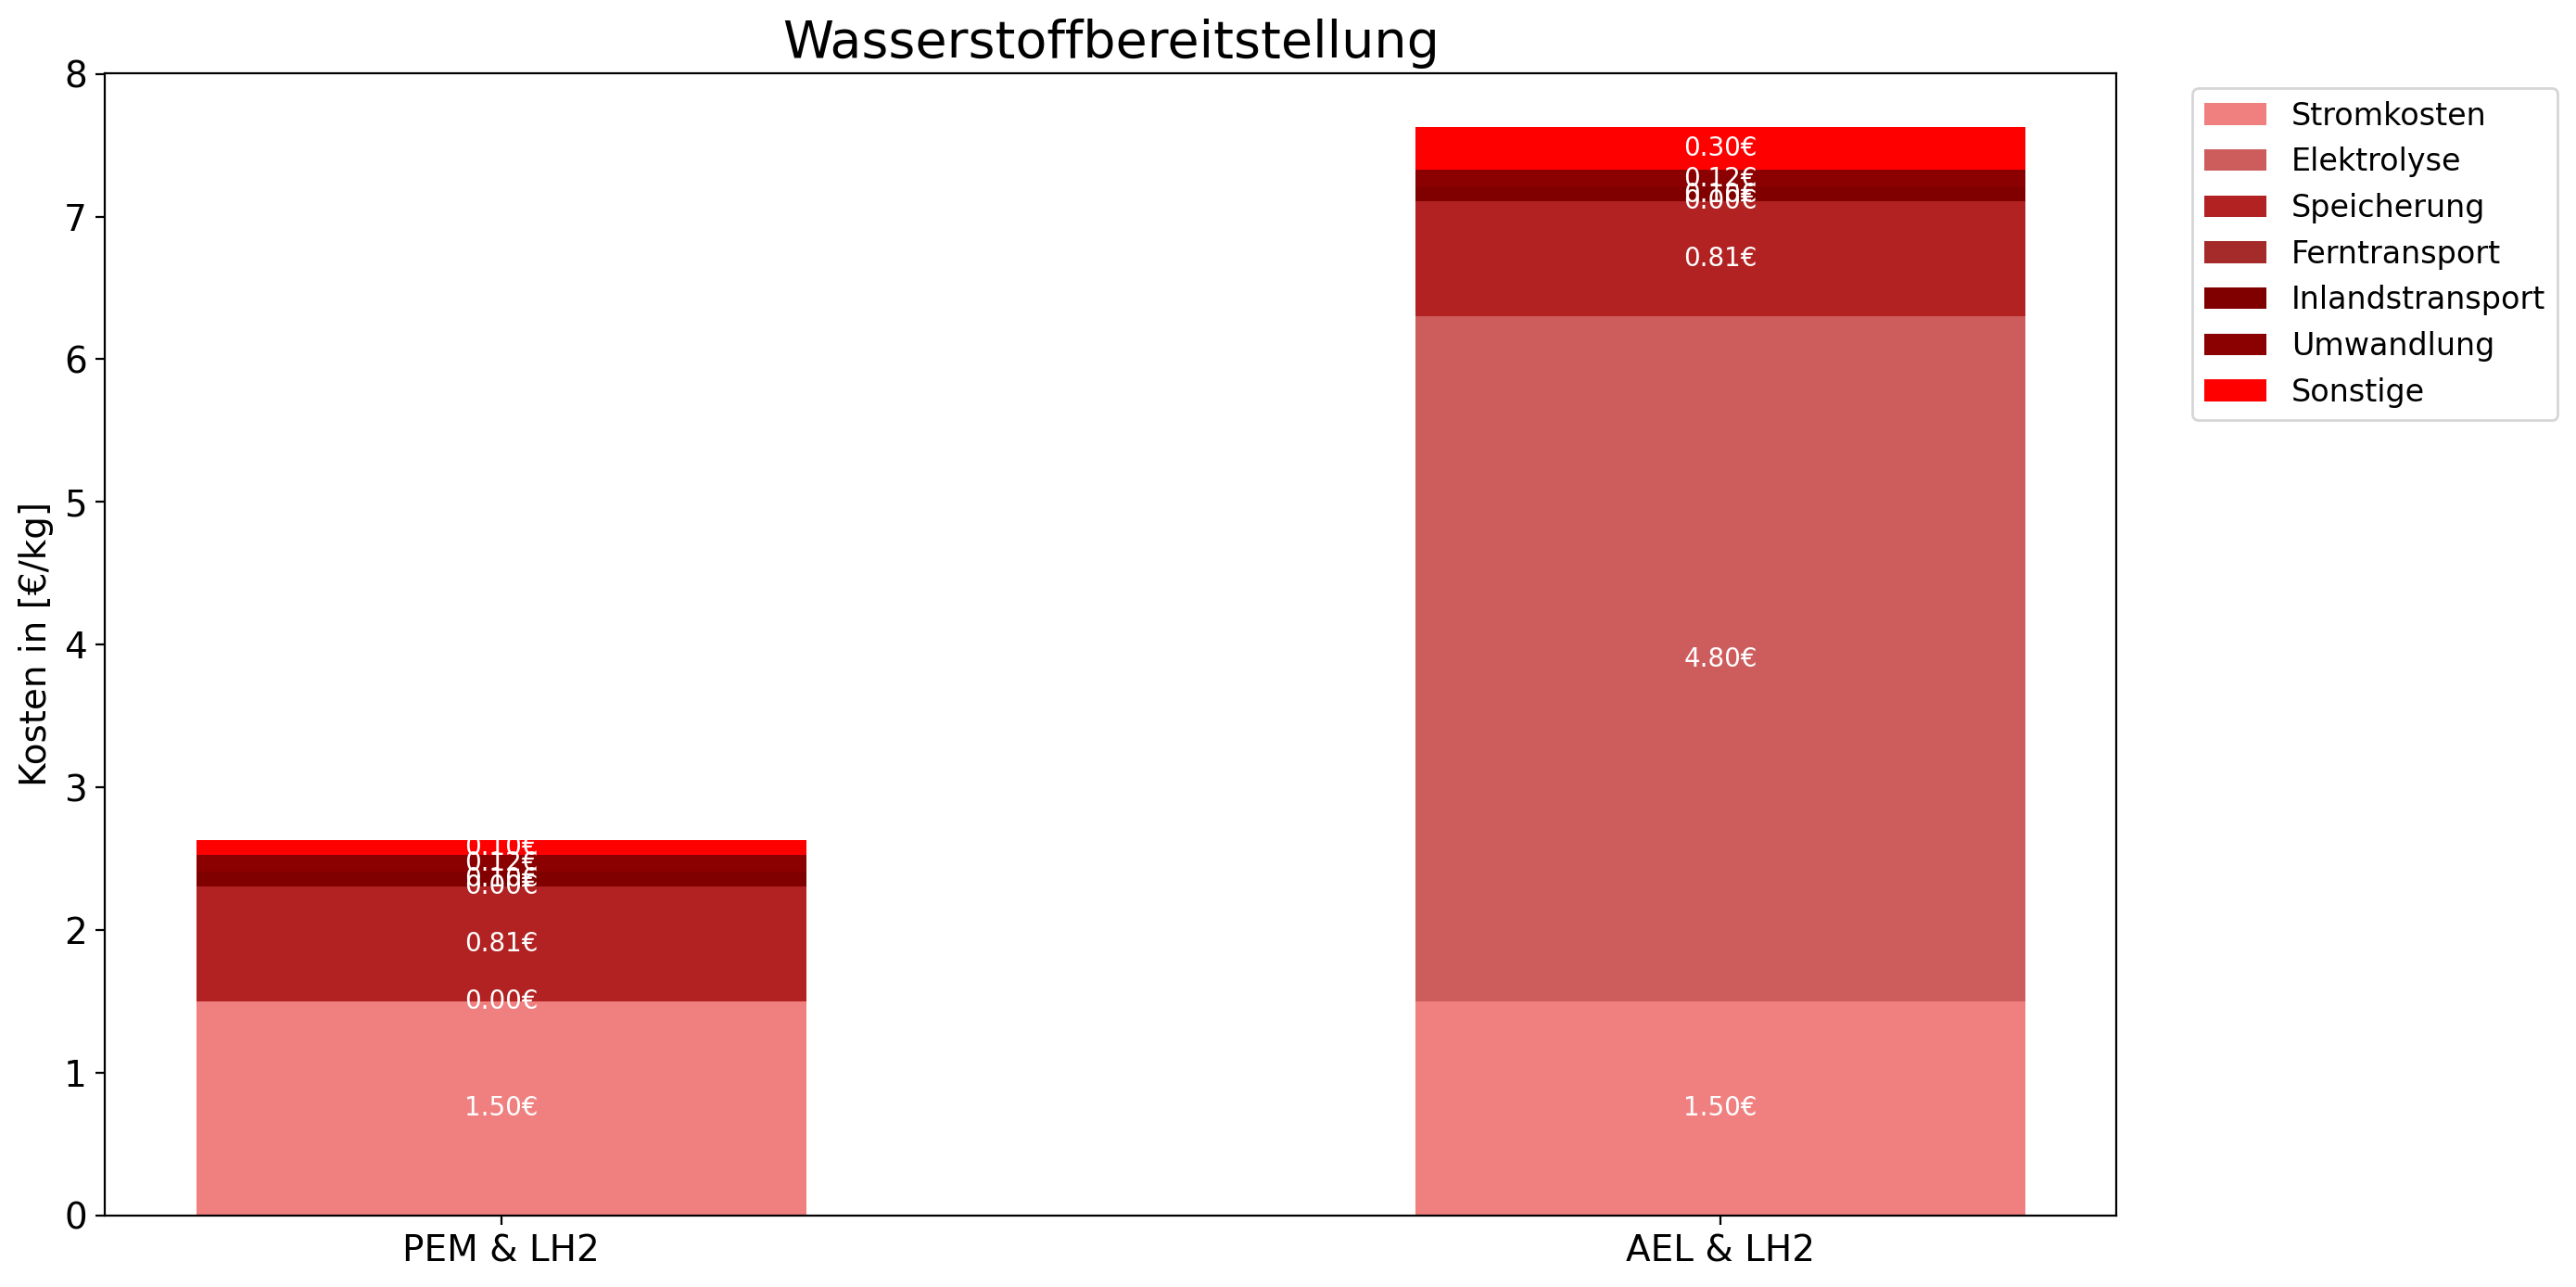

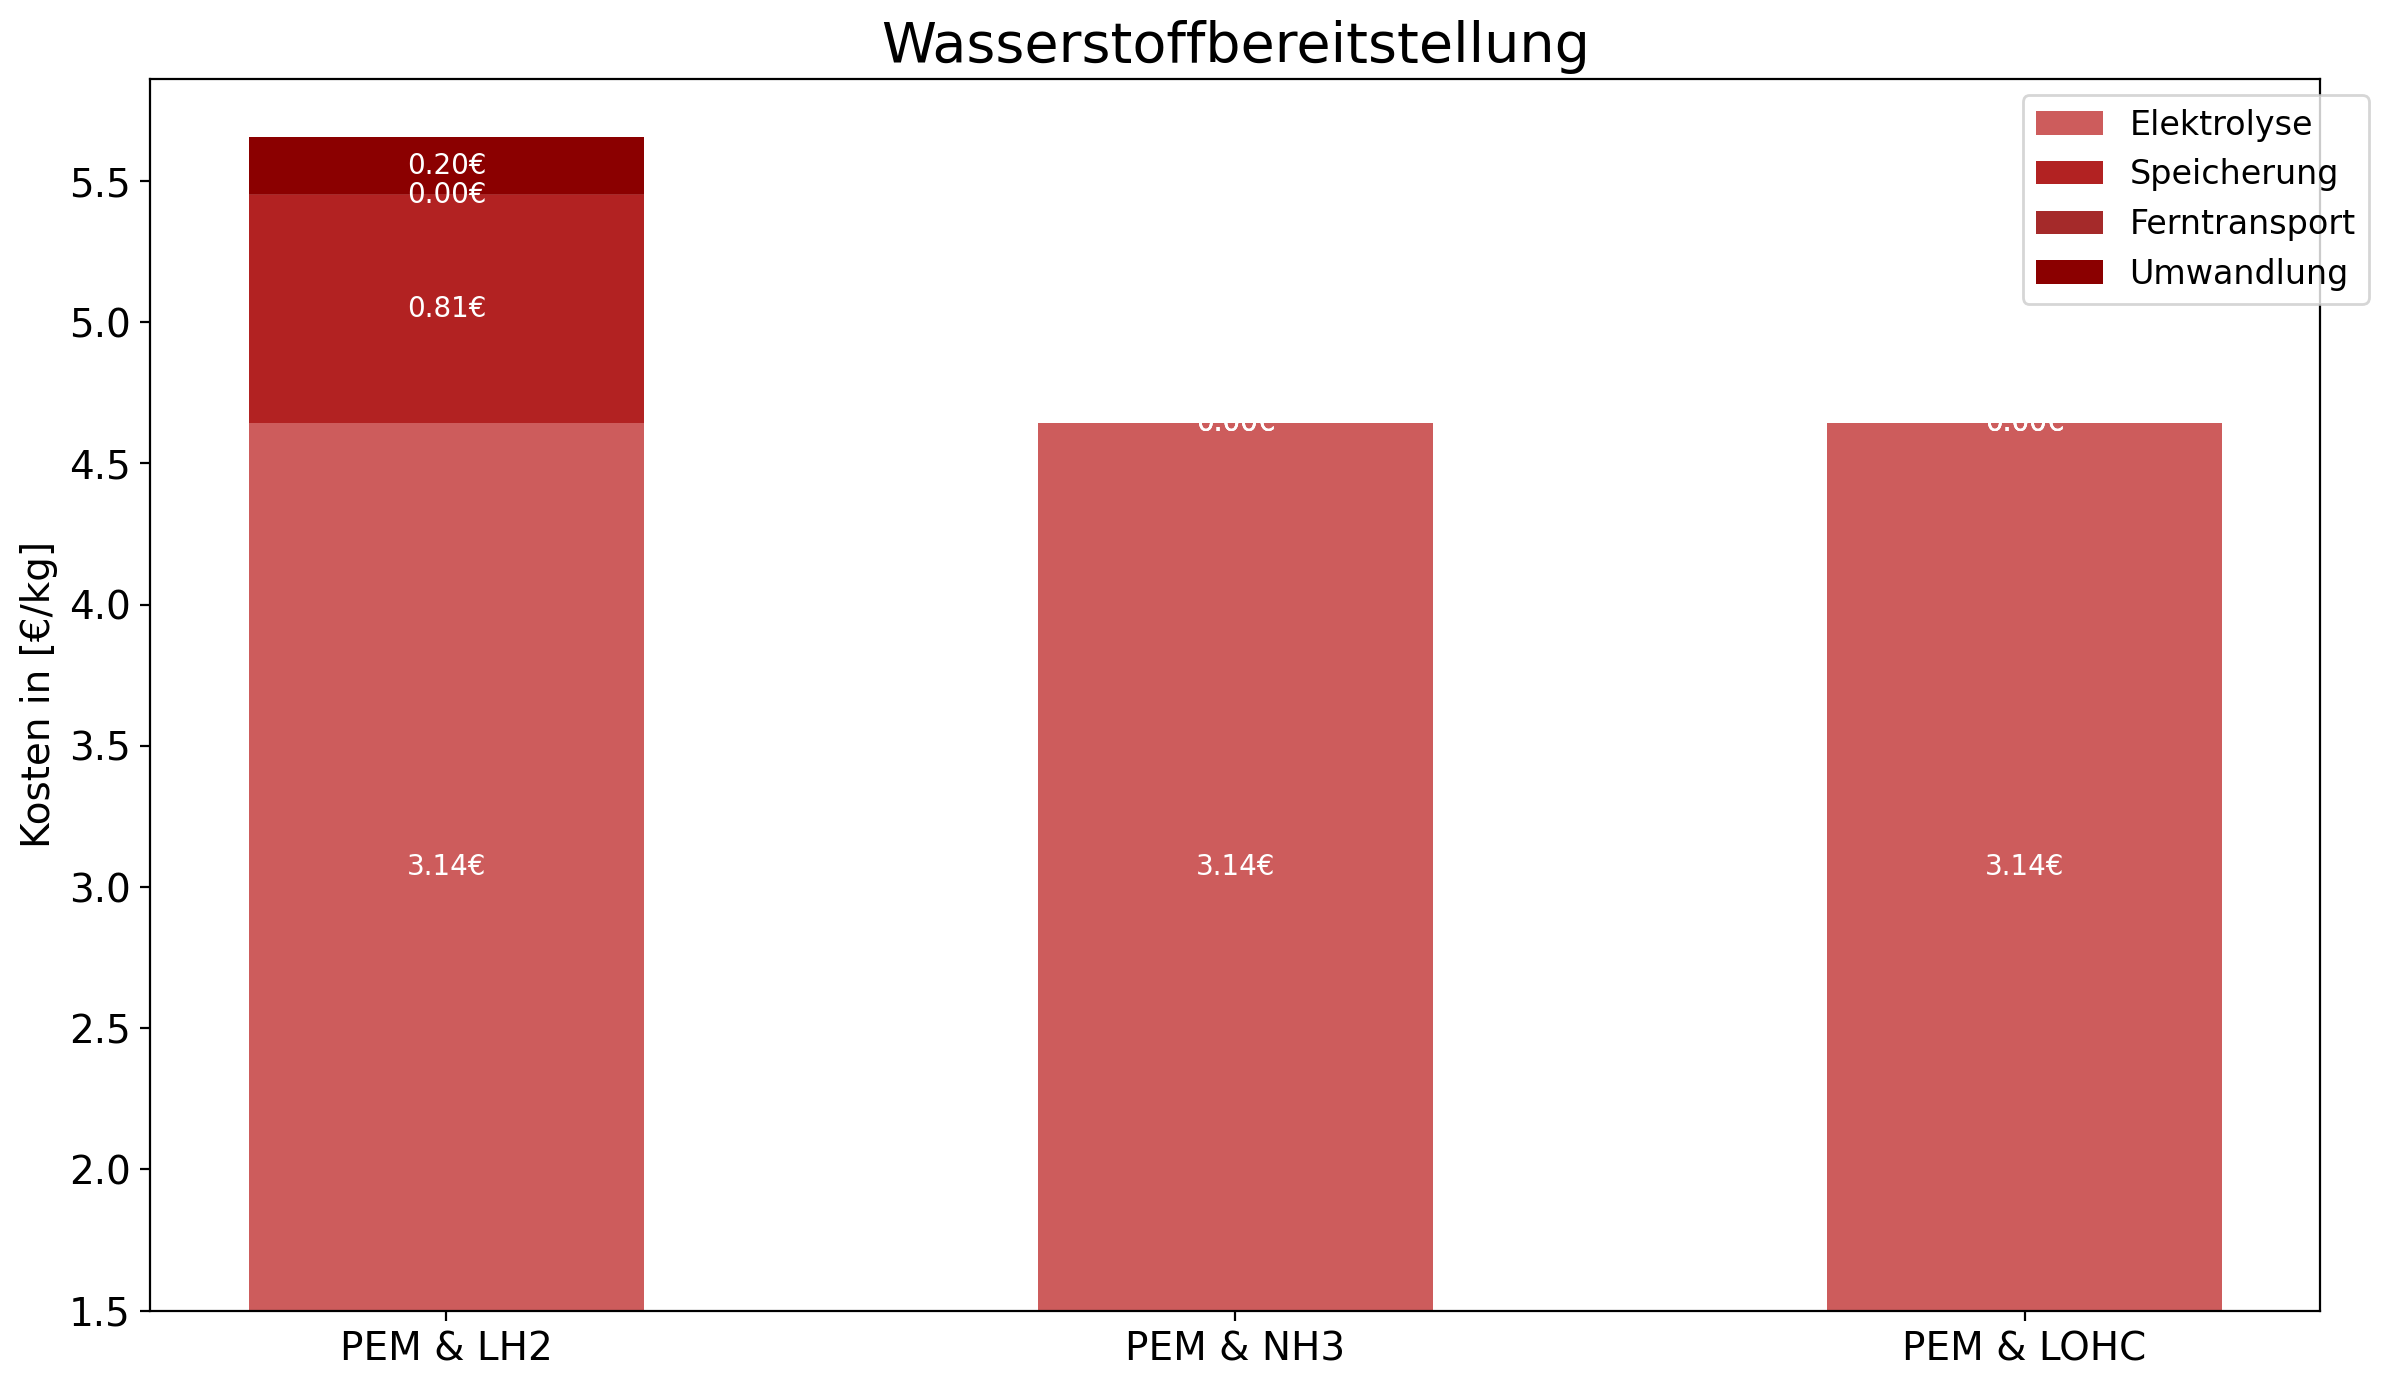

In [49]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'PEM & NH3', 'PEM & LOHC']
Stromkosten = np.array([1.5,1.5,1.5])

Elektrolyse = np.array([Linkkosten['Value [€/kg]'][0],
                        Linkkosten['Value [€/kg]'][0],
                        Linkkosten['Value [€/kg]'][0]])
Umwandlung = np.array([Linkkosten['Value [€/kg]'][2],0,0])
Ferntransport_1 = np.array([Linkkosten['Value [€/kg]'][3],0,0])
Inlandstransport = np.array([Linkkosten['Value [€/kg]'][4],0,0])

Speicherung = np.array([Speicherkosten['Value [€/kg]'][2]+Speicherkosten['Value [€/kg]'][4],0,0])

Sonstige= np.array([0.1,0.3,0.5])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(14,8))
#x_pos = [-2,0,2]
#ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€/kg]')
ax.set_title('Wasserstoffbereitstellung')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()

Ursprüngliche Grafik

In [ ]:
# Übersicht der Kilopreise

labels = ['PEM & LH2', 'AEL & LH2']
Stromkosten = np.array([Linkkosten['Value [€/kg]'][0],Linkkosten['Value [€/kg]'][1]])
Elektrolyse = np.array([2,1.5])
Speicherung = np.array([0.15,0.12])
Ferntransport_1 = np.array([1,0.2])
frachtfrafrachtfra
Umwandlung = np.array([0.7,0.3])
Sonstige= np.array([0.1,0.3])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(7,7))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€]')
ax.set_title('Wasserstoffbereitstellungskosten in €/kg Wasserstoff')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=10,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()